# Set of experiments with knowledge transfer for GANs

In order to make nice pictures of shtuff.

In [1]:
# bunch of imports
import os, sys, time
import shutil
import numpy as np
import argparse
import chainer
from PIL import Image
from evaluation import gen_images_with_condition
import yaml
import source.yaml_utils as yaml_utils
import matplotlib.pyplot as plt

import keras
from keras.applications.resnet50 import ResNet50


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_models(config):
    gen_conf = config.models['generator']
    gen = yaml_utils.load_model(gen_conf['fn'], gen_conf['name'], gen_conf['args'])
    return gen

# load the chainer model
# Use GPU num. uno
chainer.cuda.get_device(0).use()

config = yaml_utils.Config(yaml.load(open('configs/sn_projection.yml')))
gen = load_models(config)
gen.to_gpu()
chainer.serializers.load_npz('ResNetGenerator_850000.npz', gen)
xp = gen.xp

## First, make sure that it actually runs

Lets see how the smooth changes to the random inputs and class inputs affect the output

In [3]:
# experiment with fading one latent key to another
z1 = np.random.normal(size=(128,))
z2 = np.random.normal(size=(128,))

n_var = 10
n_cls = 10
imgs = []

for alpha in np.linspace(0, 1, n_cls):
    z = xp.array([z1*a + z2*(1.0-a) for a in np.linspace(0, 1, n_var)] , xp.float32)
    ys = xp.array([[1, 2]]*n_var , dtype=xp.int32)
    ws_y = xp.array([[alpha, (1.0 - alpha)]]*n_var, dtype=xp.float32)

    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        x = gen(z=z, y=ys, weights=ws_y)
    x = chainer.cuda.to_cpu(x.data)
    x = np.asarray(np.clip(x * 127.5 + 127.5, 0.0, 255.0), dtype=np.uint8)

    x = np.array(x)
    x = x.transpose(0, 2, 3, 1)
    x = np.column_stack(x)
    
    imgs.append(x)

imgs = np.row_stack(imgs)

# looks pretty smooth to me!
#Image.fromarray(imgs)

## Try and find image location on GAN manifold

In order to morph two images, lets find it's latent code first

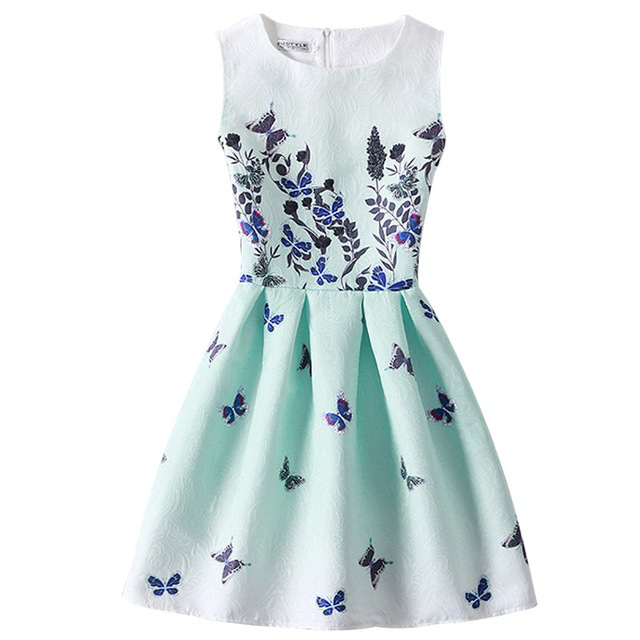

In [19]:
# load the images
img = Image.open('data/a.jpg')
img

In [5]:
# get the classes for the image
resnet = ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

In [35]:
from keras.applications.resnet50 import preprocess_input, decode_predictions
def top_classes(img):
    img = np.array(img.resize((224, 224)))
    x = np.array([img]).astype('float')
    x = preprocess_input(x)
    yp = resnet.predict(x)[0]
    I = yp.argsort()[-5:]
    W = yp[I]
    return I, W, yp

I, W, yp = top_classes(img)

print(decode_predictions(np.array([yp])))
print(I, W)

[[('n03450230', 'gown', 0.35828322), ('n03866082', 'overskirt', 0.33453745), ('n03534580', 'hoopskirt', 0.29105422), ('n02730930', 'apron', 0.0072046495), ('n04209133', 'shower_cap', 0.0012361524)]]
[793 411 601 689 578] [0.00123615 0.00720465 0.29105422 0.33453745 0.35828322]


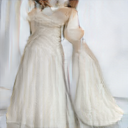

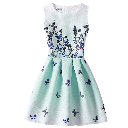

In [36]:
# generate images like that
def gen_img(I, W, z=None):
    if z is None:
        z = np.random.normal(size=(128,))
    z = xp.array([z] , xp.float32)
    ys = xp.array([I] , dtype=xp.int32)
    ws_y = xp.array([W], dtype=xp.float32)
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        x = gen(z=z, y=ys, weights=ws_y)
    x = chainer.cuda.to_cpu(x.data)
    x = np.array(x)
    return x.squeeze().transpose(1,2,0)

def display_image(x):
    x = np.asarray(np.clip(x * 127.5 + 127.5, 0.0, 255.0), dtype=np.uint8)
    display(Image.fromarray(x))

def prep_img(img):
    img = np.array(img.resize((128, 128)))
    img = (img - 127.5) / 127.5
    return img
    
z = np.random.normal(size=(128,))
x = gen_img(I, W, z)
display_image(x)
display_image(prep_img(img))

In [ ]:
from tqdm import tqdm
# objective to be minimized to find location of the image on GAN manifold
x_actual = prep_img(img)
mask = x_actual < 0.99

n_iter = 1000
best = [1.0]

with tqdm(total=n_iter) as pbar:
    def obj(z):
        x = gen_img(I, W, z)
        diff = (x - x_actual)**2
        diff = np.mean(diff)
        pbar.update(1)
        
        if diff < best[0]:
            best[0] = diff
        
        pbar.set_description(str(best[0]))
        return diff

    #z0 = np.random.normal(size=(128,))

    # minimize the difference
    from skopt import gp_minimize
    from skopt.space import Real
    
    xz = [Real(-3, 3) for _ in range(128)]
    
    sol = gp_minimize(obj, xz, n_calls=n_iter)

0.1428580606024215:   5%|▌         | 54/1000 [02:05<58:37,  3.72s/it]  

0.10244433559418703
[]


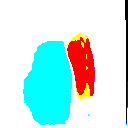

In [49]:
print(sol.fun)

zv = sol.x[:128]
cw = sol.x[128:]

print(cw)

x = gen_img(I, [1.0], zv)
display_image(x)